In [1]:
import remap
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

## Load ST reference and scRNA-seq data
##### In this example, we analyzed a mouse brain dataset generated with 10x Visium HD, masking spatial coordinates, and applied REMAP to recover cell locations using a mouse brain dataset profiled with 10x Xenium. 
##### Source data can be downloaded from the link: https://drive.google.com/drive/folders/1GOYGonul_o9pQkxOxIq-lq23WXZkHznk?usp=drive_link
##### The batch effect corrected expressions are stored in `Rdata.obsm['corrected']` and `Qdata.obsm['corrected']`. If no external batch correction is applied, setting `harmony = TRUE` in the `remap.Fit_cord_single` function will run Harmony internally to remove batch effects.

In [2]:
Rdata = ad.read_h5ad("data/brain_hd/st_data.h5ad")
Qdata = ad.read_h5ad("data/brain_hd/sc_data.h5ad")
print(Rdata)
print(Qdata)

data_name = "brain_hd"
path_name =  f"remap_output/{data_name}"

AnnData object with n_obs × n_vars = 44921 × 248
    obs: 'x_cord', 'y_cord', 'n_genes', 'n_counts', 'Cluster'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'corrected', 'covet', 'spatial'
AnnData object with n_obs × n_vars = 55823 × 12510
    obs: 'x_cord', 'y_cord', 'Cluster', 'n_genes', 'n_counts'
    var: 'n_cells'
    obsm: 'corrected', 'covet'


## Initialize neighboring gene-gene covariance estimation.

##### After training, initialized neighboring gene-gene covariance for ST and scRNA-seq will be saved to `path_name` in `npy` format, named as `st_covariance.npy` and `sc_covariance.npy`.

In [3]:
Rdata, Qdata = remap.covet_init(st_data = Rdata, sc_data = Qdata, num_covet_genes=100, k_nearest=100, num_HVG=1000, 
                 save_path = path_name, log_input = 0.0, lib_size = False)

Loading precomputed neighboring gene-gene covariance


## Fit location prediction model.

##### The predicted locations will be saved to `path_name` in `npy` format, named as `remap_loc.npy`.
##### If no external batch effect correction methods are applied, setting `harmony = True` is recommended to remove gene expression batch effect using Harmony
##### By default, we set the number of iterations to be 3.

In [4]:
pred_test = remap.Fit_cord_single(Rdata = Rdata, location_data = Rdata.obs[['x_cord', 'y_cord']], Qdata = Qdata, 
                    path_name = path_name, n_iter = 3, harmony = False)

Model is on GPU


Training, location_iter0: 100%|███████████████████████████████████████| 500/500 [01:47<00:00,  4.64it/s, loss=0.0120]


Early stopping criteria reached.


Training, covariance_iter0: 100%|████████████████████████████████████| 500/500 [03:35<00:00,  2.32it/s, loss=20.5322]

Early stopping criteria reached.



Training, location_iter1: 100%|███████████████████████████████████████| 500/500 [01:44<00:00,  4.80it/s, loss=0.0164]


Early stopping criteria reached.


Training, covariance_iter1: 100%|█████████████████████████████████████| 500/500 [02:24<00:00,  3.46it/s, loss=3.2132]

Early stopping criteria reached.



Training, location_iter2: 100%|███████████████████████████████████████| 500/500 [01:36<00:00,  5.20it/s, loss=0.0227]


Early stopping criteria reached.


##### Visualize the location prediction results and calculate the pairwise distance correlation.

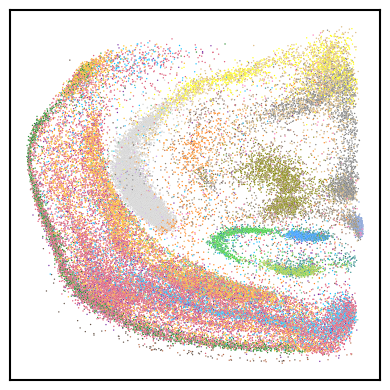

In [5]:
pred_test = np.load(f"{path_name}/remap_loc.npy")
Qdata.obsm['remap'] = pred_test

colors = {'1': '#DB4C6C', '2': '#D1D1D1', '3': '#997273', '4': '#DAB370', '5': '#FF7F0E', 
          '6': '#6D1A9C', '7': '#FEB915', '8': '#C798EE', '9': '#3A84E6', '10': '#00BFFF', 
          '11': '#787878', '12': '#15821E', '13': '#9E7A7A', '14': '#268785', '15': '#AF5F3C', 
          '16': '#808000', '17': '#FFFF00', '18': '#59BE86', '19': '#877F6C', '20': '#32CD32', 
          '21': '#7495D3', '22': '#9ACD32', '23': '#1E90FF', '24': '#FF69B4', '25': '#93796C', '26': '#554236'}
remap.scatter_plot(Qdata, colors, spatial_key = "remap", cluster_key = "Cluster", s = 1)

In [6]:
Qdata.obsm['spatial'] = np.array(Qdata.obs[['x_cord', 'y_cord']])

def sample_data(datatrain, prop = 0.5):
    from sklearn.model_selection import train_test_split
    Rdata_ind, Qdata_ind, _, _ =train_test_split(range(datatrain.shape[0]), datatrain.obs['Cluster'], test_size=prop,random_state=1, stratify=datatrain.obs['Cluster'])
    return np.sort(Qdata_ind)
    
Qdata_sample = Qdata[sample_data(Qdata), :].copy()    ## To speed up the calculation
remap.pairwise_corr(Qdata_sample, key1 = 'spatial', key2 = 'remap')

100%|█████████████████████████████████████████████████████████████████████████| 27912/27912 [00:52<00:00, 533.86it/s]


0.6445988047195752


## Cellular Neighborhood (CN) clustering and network construction
##### Performed CN clustering based on ground-truth or predicted locations. Here, cells were plotted under predicted locations and colored by ground-truth CN clusters.

In [7]:
n_clust = 15
knn = 100

Qdata.obsm['spatial'] = np.array(Qdata.obs[['x_cord', 'y_cord']])
cn_remap = remap.cn_cluster(Qdata.obs, loc_matrix = Qdata.obsm['remap'], ct_key = "Cluster", n_clust = n_clust, knn = knn)
cn_true = remap.cn_cluster(Qdata.obs, loc_matrix = Qdata.obsm['spatial'], ct_key = "Cluster", n_clust = n_clust, knn = knn)
Qdata.obs['CN_true'] = cn_true
Qdata.obs['CN_remap'] = cn_remap

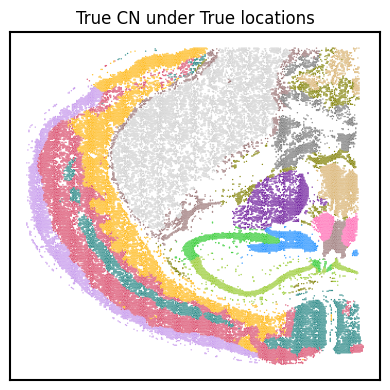

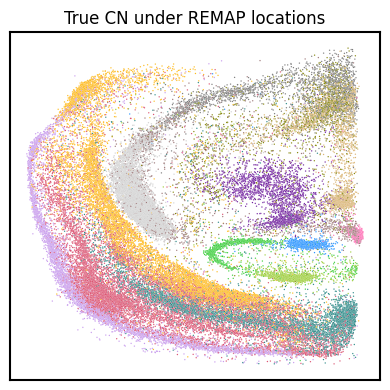

In [8]:
colors = {'1': '#268785', '2': '#997273', '3': '#808000', '4': '#FEB915', '5': '#32CD32',
          '6': '#9E7A7A', '7': '#6D1A9C', '8': '#DAB370', '9': '#C798EE', '10': '#D1D1D1', 
          '11': '#787878', '12': '#1E90FF', '13': '#9ACD32', '14': '#FF69B4', '15': '#DB4C6C'}

remap.scatter_plot(Qdata, colors, spatial_key = "spatial", cluster_key = "CN_true", s = 1, title = "True CN under True locations")
remap.scatter_plot(Qdata, colors, spatial_key = "remap", cluster_key = "CN_true", s = 1, title = "True CN under REMAP locations")

##### Construct CN spatial network. Nodes represent the centroids of CN clusters with edges drawn based on spatial proximity. Edge length corresponds to the Euclidean distance between centroids, and edge width was scaled inversely to distance. Edges can be filtered based on the spatial proximity between CN clusters. In this example, only top 25% of edges with closest spatial proximity were retained.

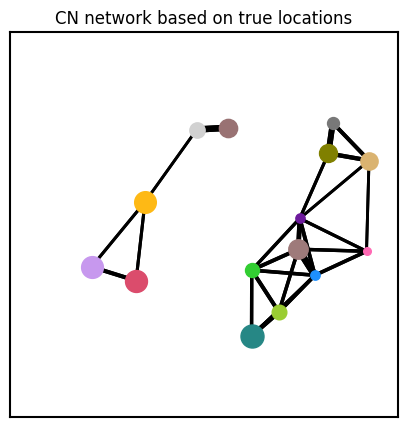

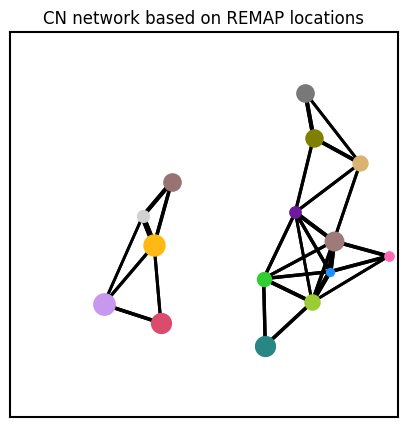

In [9]:
thre = 0.75
dist_true, _ = remap.dist_center(Qdata.obs, Qdata.obsm['spatial'], key="CN_true")
thre = np.quantile(dist_true[dist_true != 0], 0.75)

remap.cn_network_loc(Qdata.obs, location = Qdata.obsm['spatial'], cn_key = "CN_true", colors = colors, thre = thre, title = "CN network based on true locations")
remap.cn_network_loc(Qdata.obs, location = Qdata.obsm['remap'], cn_key = "CN_true", colors = colors, thre = thre, title = "CN network based on REMAP locations")


##### NMI between ground-truth and predicted CN cluster labels

In [10]:
from sklearn.metrics import normalized_mutual_info_score
print(normalized_mutual_info_score(cn_true, cn_remap))

0.6445027131990085
